## Housing Prices
#### Data Exploration, Feature Engineering, Hyperparameter Tuning, Model Explainability

In [1]:
import warnings
from utils import plot_defaults, load_data

import matplotlib.pyplot as plt
import pandas as pd

plot_defaults()
warnings.filterwarnings('ignore')

train, test = load_data()

In [2]:
from utils import create_features, score_dataset
from sklearn.ensemble import RandomForestRegressor

X_train, X_test = create_features(train, test)
y_train = train.loc[:, "SalePrice"]

### 1. Descrevendo os Dados

Este projeto não tem por objetivo fazer uma ostensiva exploração dos dados. Porém, uma breve pesquisa sobre os dados deve auxiliar na elaboração de novas 'features' para conquistar um modelo com maior acertividade.

In [3]:
data_dir = "../data/"
train = pd.read_csv(data_dir + "train.csv", index_col="Id")
test = pd.read_csv(data_dir + "test.csv", index_col="Id")
print("train shape: ", train.shape,"\ntest shape:  " ,test.shape)

train shape:  (1460, 80) 
test shape:   (1459, 79)


<AxesSubplot:>

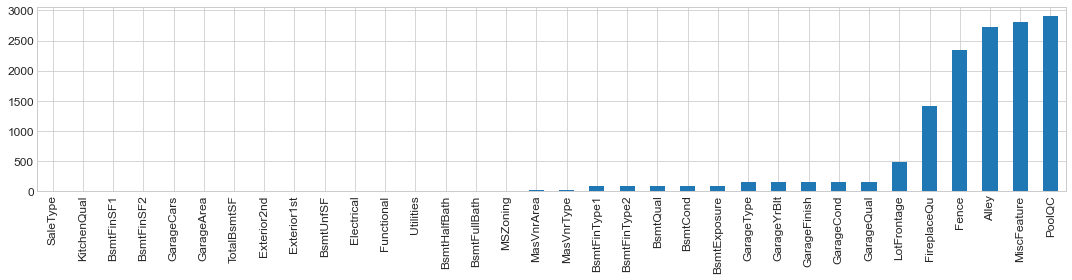

In [4]:
import seaborn as sns

missing = test.isnull().sum() + train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (15,4), fontsize=12)

Apenas 5 features apresentam mais de 25% dos valores como Nulos. E nessas features os valores nulos, conforme descrição dos dados, são pela ausência da característica no imóvel. 

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice', ylabel='Density'>

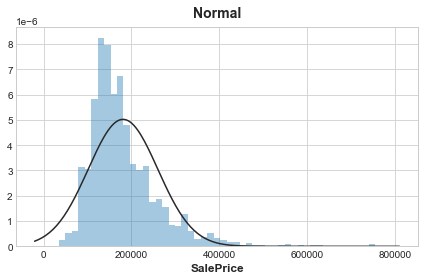

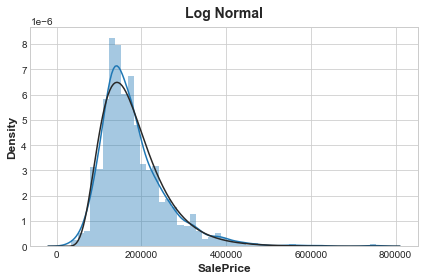

In [5]:
import scipy.stats as st
target = train['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(target, kde=False, fit=st.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(target, kde=True, fit=st.lognorm)

Os preços de venda dos imóveis estão distribuidos mais próximos de uma distribuição 'Log Normal'. Portanto o erro será calculado por RMSE (Root-mean-squared-error) dos valores log(preditos) e log(observados). Desta forma os imóveis muito caros ou baratos terão impacto equivalente no erro.  

### 2. Codificação ordinal (label encode)

In [6]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('MSSubClass') # Apesar de ser de um tipo numérico é categórica
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print("Features categóricas: ", len(qualitative),"\nFeatures numéricas:  " ,len(quantitative))

Features categóricas:  43 
Features numéricas:   35


In [7]:
from utils import impute, encode

train = impute(train)
train, qualitative = encode(train, qualitative)

### 3. Operações sobre os dados (Feature Engineering)

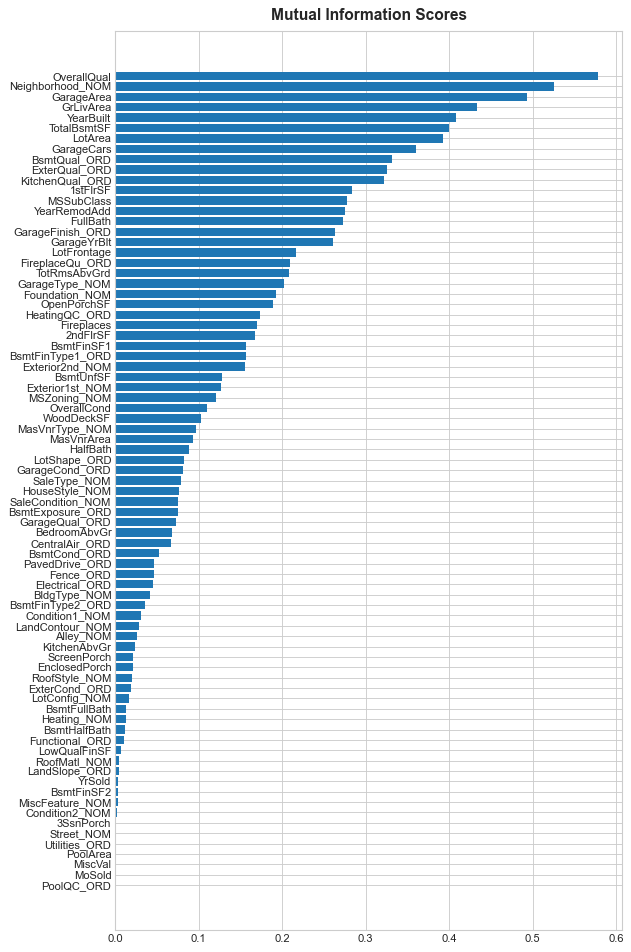

In [8]:
from utils import score_dataset, plot_mi_scores, make_mi_scores, impute

X = train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

Diferentemente da correlação que quantifica relações lineares, 'mutual information' considera em sua medida qualquer tipo de relação entre duas grandezas.

As características com os maiores MI_score com o 'target' terão maior atenção na elaboração de novas 'features', pois retornarão os melhores ganhos na redução do erro do modelo. 

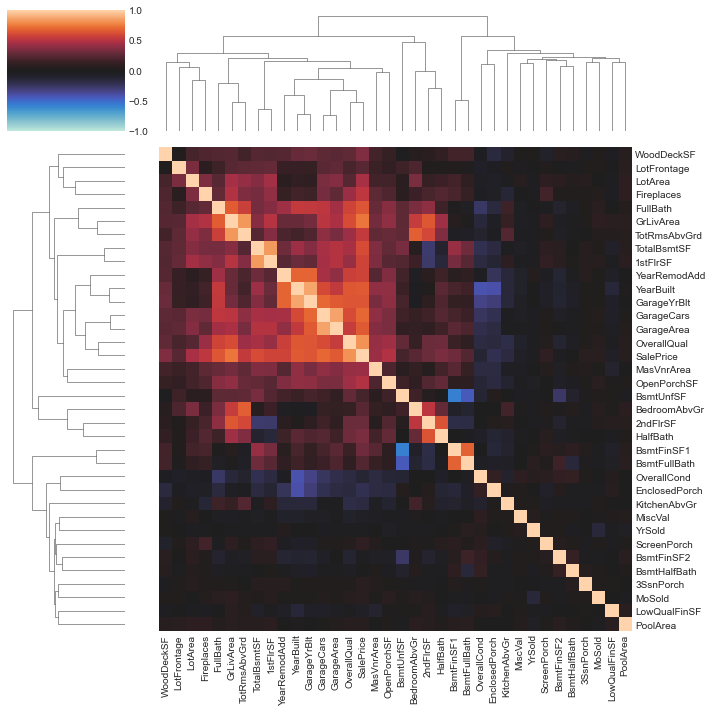

In [9]:
from utils import corrplot
corrplot(train[quantitative+['SalePrice']], annot=None, corr_method='spearman', cluster_method='average')

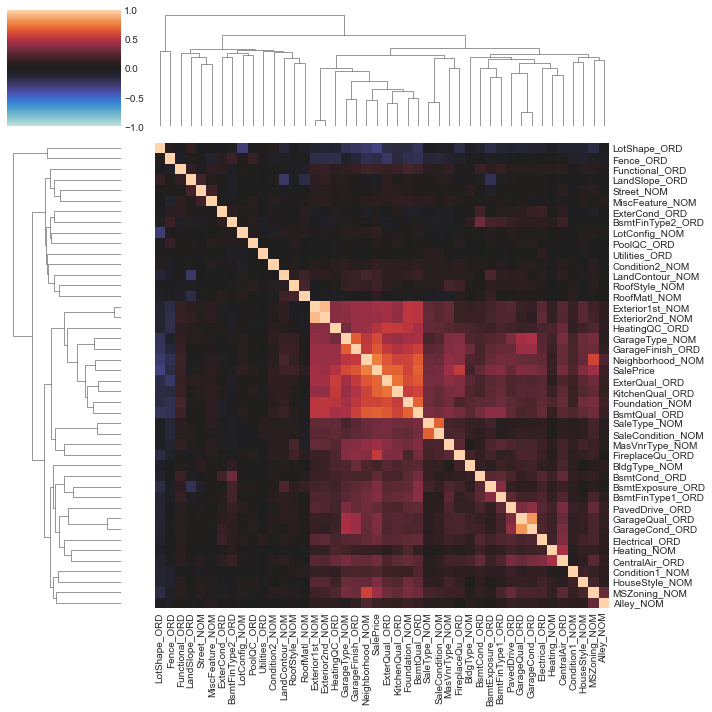

In [10]:
corrplot(train[qualitative+['SalePrice']], annot=None, corr_method='spearman', cluster_method='weighted')

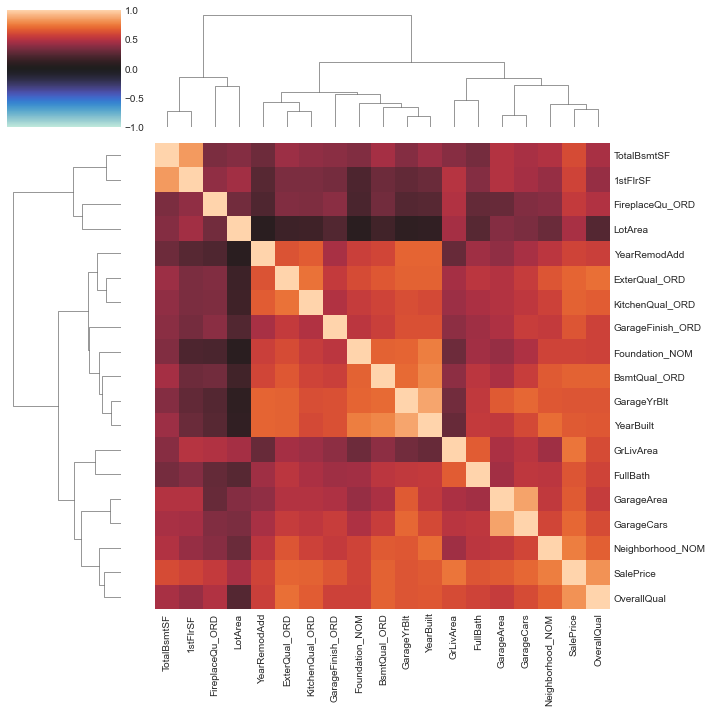

In [11]:
main_features = ['SalePrice', 'Neighborhood_NOM', 'ExterQual_ORD', 'KitchenQual_ORD', 'Foundation_NOM', 
                 'BsmtQual_ORD', 'FireplaceQu_ORD', 'GarageFinish_ORD',
                 'OverallQual', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd',
                 'GrLivArea', 'FullBath', 'TotalBsmtSF',
                 'LotArea', '1stFlrSF']
#As 3 últimas apresentaram MI_score relevante apesar de correlação baixa
corrplot(train[main_features], annot=None, corr_method='spearman', cluster_method='ward')

Estes mapas de calor com agrupamento das 'features' fornece indicações e possibilita 'insights' de ferramentas na elaboração de features. 

Como exemplos de ferramentas tem-se Clustering, Target Encoding, transformações matemáticas dentre outros abordados.

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

train, _ = load_data() #já realiza um encode de todas as features categóricas
X = train.copy()
y = X.pop('SalePrice')

score_dataset(GradientBoostingRegressor(random_state=0), X, np.log(y))

0.1270461731308373

O processo de criação de 'features' foi realizado de forma iterativa, observando o impacto na redução (melhora) da pontuação de referência a cada nova característica. Além disso também observou-se o rank de 'PermutationImportance' (aboradado mais a frente) das features em alguns casos. 

A função de pontuação foi definida utilizando validação cruzada nos dados de treino divido em 5 partes(folds).

In [13]:
from utils import create_features, load_data
from sklearn.ensemble import GradientBoostingRegressor

df_train, df_test = load_data()

X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]
log_y_train = np.log(y_train)

modelRFG = GradientBoostingRegressor(random_state=0)
score_dataset(modelRFG, X_train, np.log(y_train))

0.12144480479942722

### 4. Ajuste de parametro e Salvando as predições

In [14]:
def objective(trial):
    gbr_params = dict(        
        n_estimators=trial.suggest_int("n_estimators", 160,270),
        max_depth=trial.suggest_int("max_depth", 3, 5),
        learning_rate=trial.suggest_float("learning_rate", 2e-2, 2e-1),
        random_state=2,#trial.suggest_int("random_estate", 0, 5), 
    )
    gbr = GradientBoostingRegressor(**gbr_params)
    return score_dataset(gbr, X_train, log_y_train)

In [15]:
import optuna

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)
# gbr_params = study.best_params


In [16]:
gbr_params = dict(
    n_estimators=199,
    random_state=2,    
)
modelGBR = GradientBoostingRegressor(**gbr_params)

score_dataset(modelGBR, X_train, log_y_train)

0.12077271978282253

In [17]:
import numpy as np
modelGBR.fit(X_train, log_y_train)
X_test.fillna(value=0.0, inplace=True)
preds_submission = np.exp(modelGBR.predict(X_test))
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': preds_submission})
output.to_csv('../data/submission.csv', index=False)

### 5. Avaliando o modelo

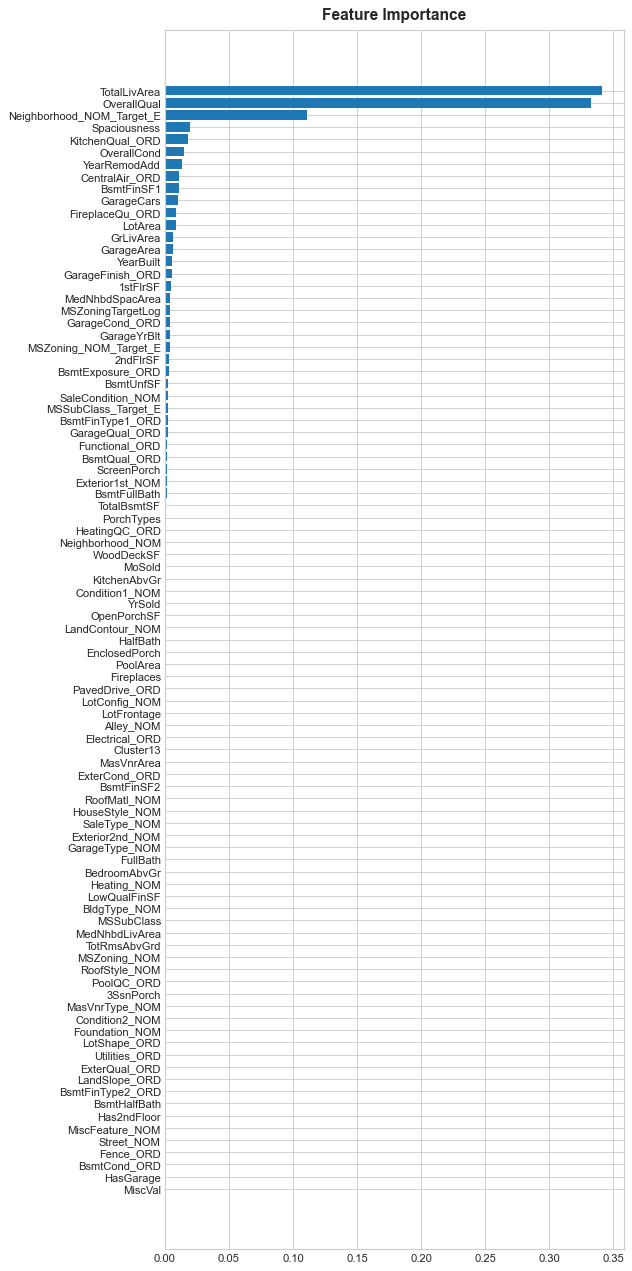

In [18]:
from utils import plot_model_importances

plot_model_importances(modelGBR.feature_importances_, X_train.columns)

Os valores de feature_importance do próprio modelo são um tanto grosseiros servindo para uma análise rápida qualitativa, e não quantitativa.

Em outras palavras, é possível saber quais são as 5-10 principais features com impacto no modelo.

In [19]:
import eli5
from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(modelGBR, scoring=score_dataset, random_state=0).fit(X_train, np.log(y_train))
perm = PermutationImportance(modelGBR, random_state=0).fit(X_train, log_y_train)

eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=12)

Weight,Feature
0.2545 ± 0.0190,TotalLivArea
0.1126 ± 0.0052,OverallQual
0.0439 ± 0.0023,Neighborhood_NOM_Target_E
0.0181 ± 0.0019,OverallCond
0.0123 ± 0.0012,Spaciousness
0.0115 ± 0.0011,YearBuilt
0.0103 ± 0.0004,LotArea
0.0097 ± 0.0015,YearRemodAdd
0.0074 ± 0.0012,BsmtUnfSF
0.0055 ± 0.0004,KitchenQual_ORD


O PermutationImportance permite uma análise um pouco mais refinada do impacto das features no modelo.

No caso acima foi utilizada a função default do GradientBoostRegressor(), na qual o modelo foi treinado.

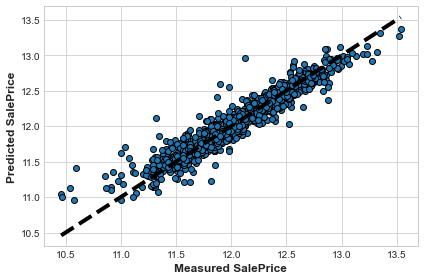

Erro(LogRMSE) do modelo treinado com SalePrice


0.12476258830854459

In [20]:
from utils import plt_cross_val_predict, error_RMSE
from sklearn.model_selection import cross_val_predict

modelGBR2 = GradientBoostingRegressor(**gbr_params)
#X_train y_train log_y_train

predict = cross_val_predict(modelGBR2, X_train, y_train, cv=3)
plt_cross_val_predict(np.log(y_train), np.log(predict))
print("Erro(LogRMSE) do modelo treinado com SalePrice")
error_RMSE(np.log(y_train), np.log(predict))

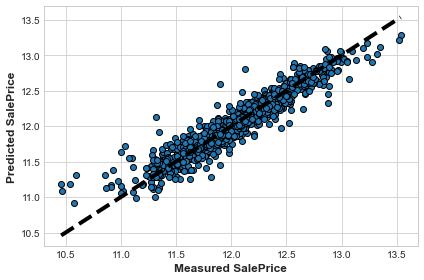

Erro(LogRMSE) do modelo treinado com log(SalePrice)


0.12774494164472378

In [21]:
log_predict = cross_val_predict(modelGBR2, X_train, log_y_train, cv=3)
plt_cross_val_predict(log_y_train, log_predict)
print("Erro(LogRMSE) do modelo treinado com log(SalePrice)")
error_RMSE(log_y_train, log_predict)

Portanto o modelo, aparentemente se beneficia de ser treinado com os valores originais de SalePrice

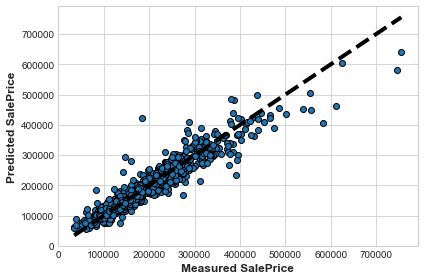

Erro(RMSE) do modelo treinado com SalePrice


24374.381332721343

In [22]:
plt_cross_val_predict(y_train, predict)
print("Erro(RMSE) do modelo treinado com SalePrice")
error_RMSE(y_train, predict)

Por fim a relação dos valores reais e preditos e o erro RMSE das predições em escala não-logarítimica, no sentido de melhor compreensão humana do desempenho do modelo. 